### Imports

In [1]:
import pandas as pd
from stimulus_helpers import *
from scipy import ndimage
import scipy

In [2]:
df = pd.read_csv('/Users/kirstenziman/Documents/predicting_attention/analysis/exp1-6_data/0dd6057w_SCRAMBLE_PILOT.csv')

In [3]:
l = list(df['image'].unique()[0::2][1:])

subjects = [b.split('_')[3] for b in l]
images   = [b.split('_')[2].split('/')[1] for b in l]
lists    = [b.split('_')[4][1] for b in l]

new_df = pd.DataFrame({'subject':subjects,'image':images,'list':lists,
                      'sub_version':1.0})

In [4]:
def movie_maker_center_of_mass(fixations, dictionary, this_list, this_version, stim_type, isolated=False):
    '''
    INPUTS:

    fixations  - pandas dataframe containing only fixation data from one subject viewing one image
    dictionary - dictionary containing two keys, one with the image name and one with the fixaiton coordinates
    stim_type  - string describing the type of attention stimulus to make: veridical / scrambled / mismatched / reversed
    isolated   - boolean describing whether the attention will be isolated (True) or be overlaid on an image (False)

    OUTPUTS:

    technically, none

    This will create and save two files:
    - mp4 video of the attention video stimulus
    - csv containing video metadata
        - # of attention chunks (num_chunks)
        - order of attention chunks (order)
        - image filename (dictionary['image'])
        - subject ID (dictionary['subject'])
    '''

    # This function can make veridical and scrambled attention spotlight videos, isolated or overlaid on an image

    lengths = []; movie_frames = []; total_counter = 0; centers = []
    order   = list(set(fixations))
    num_chunks = len(order)

    if len(order)>2:

        # scramble order for scrambled stimulus
        if stim_type=='scrambled':
            while order == list(range(1, len(order)+1)):
                remainder = order[1:]
                np.random.shuffle(remainder)
                new_list = [order[0]] + list(remainder)
                order = new_list

        # record how many chunks stay in the same place (besides the first one), if any
        number_same = sum(x == y for x, y in zip(order, list(range(1, len(order)+1))))-1

        # for each fixation chunk
        for x in order:

            length_counter = 0; tuple_list = []; total_list = []

            # for first chunk, collect the largest and smallest x and y vals
            if x==1:
            	x1_vals=[100000000000,0]; y1_vals=[100000000000,0]
            	# initialize very high and very low values, respectively

            # for each item in fixie chunk list AND each tuple
            for a,b in zip(fixations, dictionary['fixations']):

                # if item from fixie chunk list is the number from first for statement:
                if a == x:
                    tuple_list.append(b)
                    total_counter += 1
                    total_list.append(total_counter)
                    if x==1:
                    	x1_vals,y1_vals = first_bounds_update(x1_vals,y1_vals,b)

            # determine if first hotspot contains center of screen
            first_centered   = one_centered(x1_vals, y1_vals)
            reverse_centered = one_centered(y1_vals, x1_vals)

            # pass into plotting function
            c_o_m = plot_heatmap({'image':dictionary['image'], 'fixations':tuple_list},
                         filename='/Users/kirstenziman/Downloads/images_with_borders/Images_resized_greyborders/all/' + dictionary['image'],
                         alpha=.6, cmap="Greys_r", clean=False, isolated=isolated, other=None, l=this_list)

            centers.append(c_o_m)

            # save jpegs
#             for q in total_list:
#                 addin = get_addin(q)
#                 plt.savefig(dictionary['image']+addin+str(q)+'.jpg')

#         # determine frame rate given number of images
#         framerate = get_framerate()

#         if framerate!=0:
#             ending = '_'+dictionary['subject'][0]+'_L'+str(this_list)+'_V'+str(this_version)+'_'+stim_type+'_freeview_iso'+str(isolated)

#         # compile and save video
#             (
#             ffmpeg
#             .input('*.jpg', pattern_type='glob', framerate=framerate)
#             .output(dictionary['image']+ending+'.mp4')
#             .run()
#             )

#             # remove leftover jpeg images
#             remove_jpegs()

#         else:
#             print('framerate is zero for '+dictionary['image'])

#             for file_name in os.listdir('.'):
#                 if file_name.endswith('.jpg'):
#                     os.remove(file_name)

#         meta = pd.DataFrame({'image':dictionary['image'],'subject':dictionary['subject'],'num_chunks':num_chunks, 'order':[order], 'center_first':str(first_centered), 'center_first_reverse':str(reverse_centered), 'chunks_same': number_same, 'proportion_same':number_same/(len(order)-1), 'x1_vals':[x1_vals], 'y1_vals':[y1_vals]})

#         meta.to_csv(dictionary['image']+ending+'.csv')

    else:
        print('len(k) <= 2: '+dictionary['image'])

    return(centers)

In [5]:
df = pd.read_csv('stim1_example.csv') 
counter = 0

scrambled_centers = []; veridical_centers = []

for idx,row in new_df.iterrows():
    
    free_view   = get_gaze(row['subject'],int(row['list']),int(row['sub_version']),row['image'])
    free_fixies = get_fixies(free_view) 
    free_dicts  = make_the_dicts(free_view)

    center_scram = movie_maker_center_of_mass(free_fixies, free_dicts, int(row['list']), row['sub_version'], 'scrambled', isolated=False)
    center_verid = movie_maker_center_of_mass(free_fixies, free_dicts, int(row['list']), row['sub_version'], 'veridical', isolated=False)
    
    scrambled_centers.append(center_scram)
    scrambled_centers.append(center_verid)
    
    counter +=1; print(counter)

In [9]:
v_cents = scrambled_centers[1::2]
s_cents = scrambled_centers[0::2]

In [19]:
v_cents
v_dists = []

for v in v_cents:
    
    dists = []

    # for each pair of points in the centers list:
    for idx,x in enumerate(v[:-1]):
        distance = (((v[idx+1][0]-x[0])**2)+((v[idx+1][1]-x[1])**2))**.5
        dists.append(distance)
    v_dists.append(np.mean(dists))

In [20]:
len(v_dists)
np.mean(v_dists)

253.21673434952598

<Axes: ylabel='Count'>

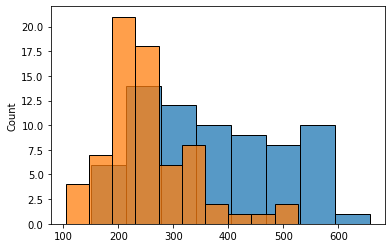

In [42]:
sb.histplot(s_dists)
sb.histplot(v_dists)

In [51]:
correct = pd.read_csv('stim_prop_correct.csv')

In [79]:
new_df['s_dist'] = s_dists
new_df['v_dist'] = v_dists

new_df.head(n=3)

,subject,image,list,sub_version,s_dist,v_dist
0,pp61,498155.bmp,2,1.0,657.648609,344.391746
1,pp100,1592581.bmp,3,1.0,559.400518,297.681562
2,pp71,1159572.bmp,1,1.0,449.292711,204.608818


In [81]:
correct.head(n=3) #['unique_image_label'].str.split('/')#.str.split('_')

correct['s_dist']=np.nan
correct['v_dist']=np.nan

In [82]:
for idx,x in new_df.iterrows():
    
    im = x['image']
    
    s = x['s_dist']
    v = x['v_dist']
    
    correct.loc[correct['unique_image_label'].str.contains(im),'s_dist'] = s
    correct.loc[correct['unique_image_label'].str.contains(im),'v_dist'] = v
    

In [85]:
correct['dist_diff'] = correct['s_dist'] - correct['v_dist']

0     164.708915
1     111.278533
2      67.080675
3      19.514907
4     244.683894
         ...    
65    -51.296965
66    276.861923
67    251.780104
68    -59.557555
69    156.943643
Name: dist_diff, Length: 70, dtype: float64

In [146]:
from scipy.stats.stats import pearsonr

pearsonr(correct['dist_diff'],correct['Percent correct'])

/var/folders/59/tcvs1l0j4ld27ynbn58_v9hh0000gn/T/ipykernel_79766/4050130332.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.24703579322435437, pvalue=0.03923562480444456)

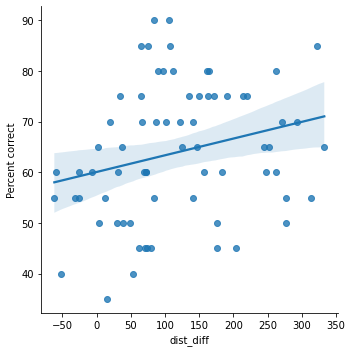

In [88]:
sb.lmplot(x='dist_diff',y='Percent correct',data=correct)

### EXTRAS

In [106]:
# s_cents[0]

(548.7872340425532, 807.1914893617026)

In [6]:
# y<=1050.00 and x<=1680.00:

# center location

# center_x = 1050/2
# center_y = 1680/2

In [103]:
# calculate the average dist from center for each

In [7]:
#s_cents[0][0][0] - center_x

In [8]:
#10/2

In [9]:
# v_cent_dfs = []
# datframe['half'] = np.nan


# for idx,vvv in enumerate(v_cents):
#     datframe = pd.DataFrame(vvv)
#     # print(datframe.shape)
#     datframe = datframe[1:]
#     # print(datframe.shape)
#     datframe['number'] = idx
#     datframe['blob_number'] = range(1,datframe.shape[0]+1)
    
#     datframe['half'] = np.nan #datframe.shape[0]/2
    
#     if datframe.shape[0]%2 == 0:
#         middle = datframe.shape[0]/2
        
#         datframe.loc[datframe['blob_number']<=middle,'half'] = 'first'
#         datframe.loc[datframe['blob_number']> middle,'half'] = 'second'
    
#     else:
#         middle_low = np.floor(datframe.shape[0]/2)
#         middle_up  = np.ceil(datframe.shape[0]/2)
        

    
#     v_cent_dfs.append(pd.DataFrame(datframe))
    
# vcd = pd.concat(v_cent_dfs)

In [10]:
#vcd.groupby(['number','half']).mean()

In [11]:
# s_cent_dfs = []
# datframe['half'] = np.nan

# for idx,sss in enumerate(s_cents):
#     datframe = pd.DataFrame(sss)
#     # print(datframe.shape)
#     datframe = datframe[1:]
#     # print(datframe.shape)
#     datframe['number'] = idx
#     datframe['blob_number'] = range(1,datframe.shape[0]+1)
    
#     datframe['half'] = np.nan #datframe.shape[0]/2
    
#     if datframe.shape[0]%2 == 0:
#         middle = datframe.shape[0]/2
        
#         datframe.loc[datframe['blob_number']<=middle,'half'] = 'first'
#         datframe.loc[datframe['blob_number']> middle,'half'] = 'second'
    
#     else:
#         middle_low = np.floor(datframe.shape[0]/2)
#         middle_up  = np.ceil(datframe.shape[0]/2)
        

    
#     s_cent_dfs.append(pd.DataFrame(datframe))
    
# scd = pd.concat(s_cent_dfs)

In [12]:
#scd.groupby(['number','half']).mean()

In [13]:
# s_cents
# s_dists = []

# for s in s_cents:
    
#     dists = []

#     # for each pair of points in the centers list:
#     for idx,x in enumerate(s[:-1]):
#         distance = (((s[idx+1][0]-x[0])**2)+((s[idx+1][1]-x[1])**2))**.5
#         dists.append(distance)
#     s_dists.append(np.mean(dists))

In [14]:
# len(s_dists)
# np.mean(s_dists)

In [15]:
#scipy.stats.ttest_rel(s_dists, v_dists)

In [16]:
#scipy.stats.sem(s_dists)

In [17]:
#scipy.stats.sem(v_dists)

In [18]:
#np.std(s_dists)

In [19]:
#np.std(v_dists)

In [20]:
#s_cents

In [21]:
#ndimage.measurements.center_of_mass(array)

In [22]:
# df = pd.DataFrame(free_dicts['fixations'])
# df['chunk'] = free_fixies

# array = np.array(df[df['chunk']==1][[0,1]])
# array

In [23]:
# len(free_fixies)

In [24]:
# free_fixies

In [ ]:
# ('stim_prop_correct.csv')

In [25]:
# calculate distances between blobs

# d=√ ( (x_2-x_1)²+ (y_2-y_1)²)

# dists = []

# # for each pair of points in the centers list:
# for idx,x in enumerate(centers[:-1]):
#     distance = (((centers[idx+1][0]-x[0])**2)+((centers[idx+1][1]-x[1])**2))**.5
#     dists.append(distance)

In [26]:
# distance = ((x[0]-centers[idx+1][0])**2)+((x[1]-centers[idx+1][1])**2)**.5
# centers[idx+1][0]

In [27]:
# np.mean(dists)

In [28]:
# centers

In [29]:
# (((608-924)**2)+((513-328)**2))**.5

In [10]:
# make stim 1 csv

In [30]:
# df = pd.read_csv('stim1_example.csv') 
# df.head(n=2)

In [31]:
# counter = 0

# for idx,row in df.iterrows():
    
#     free_view   = get_gaze(row['subject'],int(row['list']),int(row['sub_version']),row['image'])
#     free_fixies = get_fixies(free_view) 
#     free_dicts  = make_the_dicts(free_view)

#     movie_maker(free_fixies, free_dicts, int(row['list']), row['sub_version'], 'scrambled', isolated=True)
#     movie_maker(free_fixies, free_dicts, int(row['list']), row['sub_version'], 'veridical', isolated=True)
    
#     counter +=1; print(counter)